# Neutrino direction reconstruction from reco Pol.


### Jan 15, 2021

## Code

In [2]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
import pyrex.custom.ara as ara


Welcome to JupyROOT 6.18/04


In [3]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


In [4]:
def nuDirReco(polVec,propVec,viewAng):
    propVec = -propVec
    recoDir = np.sin(viewAng)*polVec-np.cos(viewAng)*propVec
    return recoDir

def SphericalToCartesian(phi, theta):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)

    return np.array([x,y,z])

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol
chAngle = 55.8 #Cherenkov angle in ice

In [49]:
appended_data = []
import os
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/noiseOn/window_Sol0/"):#Loop over desired directory
        if (filename.startswith("pol_quant_noise")): #extension, .root in this case
            name = os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/noiseOn/window_Sol0", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data) 
# recoNu = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/debug/pol_quant_noiseless.pkl")
recoNu = recoNu.loc[abs(recoNu.maxV)>1]
recoNu = recoNu.loc[abs(recoNu.maxV)<1450]
recoNu = recoNu.loc[abs(recoNu.maxH)>1]
recoNu = recoNu.loc[abs(recoNu.maxH)<1450]
recoNu = recoNu.loc[recoNu.theta_reco>=np.pi/2]
# recoNu = recoNu.loc[recoNu.weight>1E-100]
recoNu["SNR_V"] = abs(recoNu.maxV)/recoNu.rmsV
recoNu["SNR_H"] = abs(recoNu.maxH)/recoNu.rmsH
# recoNu = recoNu.loc[abs(recoNu.SNR_H-5)<1]
recoNu = recoNu.loc[recoNu.SNR_H>=5]
recoNu = recoNu.loc[recoNu.SNR_V>=5]
print(len(recoNu))


array2 = []
R_True = []
R_Reco = []
propVec = []
dot = []
nnu_Reco = []
for i in recoNu.itertuples(): 
    thetaHat = np.array([np.cos(i.theta_reco)*np.cos(i.phi_reco), np.cos(i.theta_reco)*np.sin(i.phi_reco), -np.sin(i.theta_reco)])
    phiHat = np.array([-np.sin(i.phi_reco), np.cos(i.phi_reco),0])
    if(i.powerH==0 or i.powerV==0):
        R_Reco.append(np.nan)
        R_True.append(np.nan)
        array2.append(np.nan)
        dot.append(np.nan)
        nnu_Reco.append(np.nan)
        continue
    R_Reco.append(np.sqrt(i.powerH/i.powerV))
#     R_Reco.append(abs(i.peak_H/i.peak_V))
    R = np.dot(i.PolTrue,phiHat)/(np.dot(i.PolTrue,thetaHat))
    R_True.append(R)
    polRecoAntenna = util.PolVectorRecoPower_debug(i.powerV,i.powerH, i.theta_reco, i.phi_reco,np.sign(R))
    array2.append(polRecoAntenna)#     array2.append(util.PolVectorReco_debug(i.peak_V,i.peak_H, i.theta_reco, i.phi_reco,np.sign(R)))
    phi_launch = np.arctan2(i.dirProp[1],i.dirProp[0])
    theta_launch = np.pi-i.launch_ang
    launchVec = -1*SphericalToCartesian(phi_launch,theta_launch)
    polVecSrc = rotatePolVector(launchVec,i.dirProp,polRecoAntenna)
    propVec = np.array([np.sin(i.theta_reco)*np.cos(i.phi_reco),np.sin(i.theta_reco)*np.sin(i.phi_reco),np.cos(i.theta_reco)])
    dot.append(np.dot(propVec,i.PolTrue))
    nnu_Reco.append(nuDirReco(-polVecSrc,launchVec,i.view_ang))

recoNu["PolReco2"] = array2
recoNu["nnu_Reco"] = nnu_Reco
# recoNu["PolReco2"] = util.PolVectorReco(recoNu.maxV, recoNu.maxH, recoNu.theta_reco,recoNu.phi_reco)

recoNu["R_True"] = R_True
recoNu["R_Reco"] = R_Reco
recoNu["dotProd"] = dot
recoNu = recoNu.dropna()

# recoNu = recoNu.loc[abs(np.degrees(recoNu.view_ang)-56.037)<5]


Px_true = np.array([element[0] for element in recoNu.PolTrue])
Py_true = np.array([element[1] for element in recoNu.PolTrue])
Pz_true = np.array([element[2] for element in recoNu.PolTrue])

Px_reco = np.array([element[0] for element in recoNu.PolReco2])
Py_reco = np.array([element[1] for element in recoNu.PolReco2])
Pz_reco = np.array([element[2] for element in recoNu.PolReco2])


nnuX_true = np.array([element[0] for element in recoNu.nnu])
nnuY_true = np.array([element[1] for element in recoNu.nnu])
nnuZ_true = np.array([element[2] for element in recoNu.nnu])

nnuX_reco = np.array([element[0] for element in recoNu.nnu_Reco])
nnuY_reco = np.array([element[1] for element in recoNu.nnu_Reco])
nnuZ_reco = np.array([element[2] for element in recoNu.nnu_Reco])

thetaNnu_true = np.degrees(np.arccos((nnuZ_true)))
thetaNnu_reco = np.degrees(np.arccos((nnuZ_reco)))
phiNnu_true = np.degrees(np.arctan2(abs(nnuY_true),abs(nnuX_true)))
phiNnu_reco = np.degrees(np.arctan2(abs(nnuY_reco),abs(nnuX_reco)))



recoNu["delta"] = thetaNnu_reco-thetaNnu_true
# recoNu["thetaPol_reco"] = thetaPol_reco
# recoNu["thetaPol_true"] = thetaPol_true

recoNu["deltaPhi"] = phiNnu_reco-phiNnu_true
# # recoNu.loc[np.sign(recoNu.R_True)-recoNu.R_recoSign==0]


# delta = thetaPol_reco-thetaPol_true
# deltaPhi = phiPol_reco-phiPol_true
recoNu = recoNu.dropna()
# delta = delta[~np.isnan(delta)]


38619


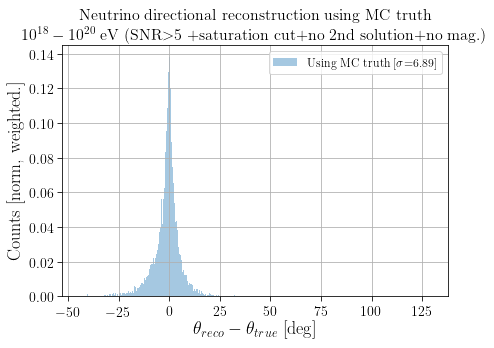

In [50]:
delta = recoNu["delta"]
plt.figure(figsize=(7,5))
delta_mean= np.ma.average(delta,weights=recoNu.weight)
variance = np.dot(recoNu.weight, (delta - delta_mean) ** 2) / recoNu.weight.sum()
delta_std = np.sqrt(variance)

sns.distplot(delta, bins=1000,hist_kws={'weights': recoNu.weight},norm_hist=True,kde=False,label = "Using MC truth [$\sigma$=%0.2f]"%(delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm, weighted.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Neutrino directional reconstruction using MC truth \n $10^{18}-10^{20}$ eV (SNR$>$5 +saturation cut+no 2nd solution+no mag.)", fontsize=16)
# plt.xlim(-50,50)
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_noNoiseOmega.png', dpi=250)


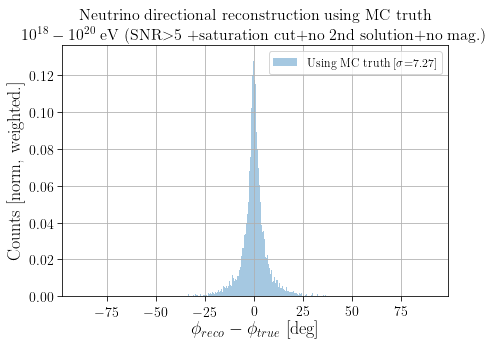

In [53]:
delta = recoNu["deltaPhi"]
plt.figure(figsize=(7,5))
delta_mean= np.ma.average(delta,weights=recoNu.weight)
variance = np.dot(recoNu.weight, (delta - delta_mean) ** 2) / recoNu.weight.sum()
delta_std = np.sqrt(variance)

sns.distplot(delta, bins=1000,hist_kws={'weights': recoNu.weight},norm_hist=True,kde=False,label = "Using MC truth [$\sigma$=%0.2f]"%(delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\phi_{reco}-\phi_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm, weighted.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Neutrino directional reconstruction using MC truth \n $10^{18}-10^{20}$ eV (SNR$>$5 +saturation cut+no 2nd solution+no mag.)", fontsize=16)
# plt.xlim(-50,50)
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_noNoiseOmega.png', dpi=250)


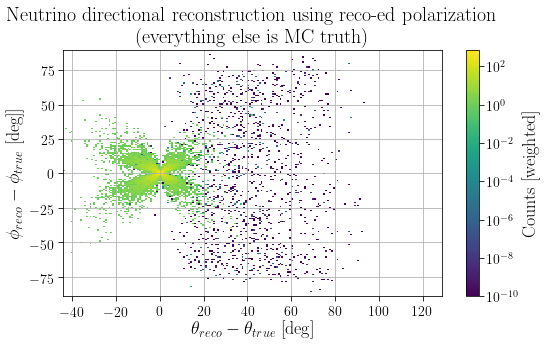

In [57]:
import matplotlib.colors as colors
plt.figure(figsize=(8,5))

plt.hist2d(recoNu["delta"],recoNu["deltaPhi"], bins = 200,norm=colors.LogNorm(vmin=1E-10), weights=recoNu.weight);
plt.colorbar(label="Counts [weighted]")
plt.xlabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
plt.ylabel("$\phi_{reco}-\phi_{true}$ [deg]]")
plt.title("Neutrino directional reconstruction using reco-ed polarization\n (everything else is MC truth)")
# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.xticks(np.arange(0,100,10))
# plt.yticks(np.arange(-360,360,60))
plt.grid()
# plt.plot(x,y,"--", c = "red", alpha = 0.3, label = "$y=x$")
# plt.legend()
plt.tight_layout()
plt.savefig(my_path_plots+'/NuDirReco/deltaPhiDeltaTheta.png', dpi=250)